In [1]:
import pdf
import util
import os
import chunking
import vector_store as vs
from tqdm import tqdm
from langchain_qdrant import FastEmbedSparse
from langchain_openai import OpenAIEmbeddings
import api
import retrieval
import chatbot
import re
from IPython.display import Image, display
import evaluation as eval
import json

/Users/lucachangretta/opt/anaconda3/envs/Thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

pdf_paths = ["Dataset/File1_manual.pdf", "Dataset/File2_manual.pdf", "Dataset/File3_manual.pdf", "Dataset/File4_manual.pdf"]
query_path = "query.txt"

individual_pages_folder = 'manual_individual_pages'
all_contents_folder = 'manual_all_contents'

text_collection_name = 'manual_texts_no_diff'
caption_collection_name = 'manual_captions_no_diff'

# Extract Content

In [3]:
util.clear_folder(individual_pages_folder)
util.clear_folder(all_contents_folder)

for pdf_path in pdf_paths:
    file = pdf.PDF(pdf_path)
    file.extract_pages()
    all_texts = file.combine_pages_txt()

    # Extract single pages
    image_save_dir = f"{all_contents_folder}/{file.name}/Images"
    os.makedirs(image_save_dir, exist_ok=True)
    for page in file.pages:
        page_text_save_dir = f"{individual_pages_folder}/{file.name}"
        os.makedirs(page_text_save_dir, exist_ok=True)
        util.save_text_to_file(page.text, f"{page_text_save_dir}/Page{page.page_num+1}.txt")
        for image in page.images:
            image_save_path = f"{image_save_dir}/Page{image.parent_page_num+1}_Figure{image.index+1}.{image.ext}"
            image.save(image_save_path)
            image.path = image_save_path

    # Save combined texts
    all_texts_save_dir = f"{all_contents_folder}/{file.name}"
    os.makedirs(all_texts_save_dir , exist_ok=True)
    util.save_text_to_file(all_texts, f"{all_texts_save_dir}/{file.name}.txt")

    # Save all the images info
    images_info_save_dir = f"{all_contents_folder}/{file.name}"
    os.makedirs(images_info_save_dir, exist_ok=True)
    file.save_images_info(f"{images_info_save_dir}/Images_info.json")


manual_individual_pages is cleared!
manual_individual_pages is ready for new content.
manual_all_contents is cleared!
manual_all_contents is ready for new content.


Processing pages of file Dataset/File1_manual.pdf: 100%|██████████| 2/2 [00:00<00:00, 57.47it/s]


Saved content to manual_all_contents/File1_manual/Images_info.json


Processing pages of file Dataset/File2_manual.pdf: 100%|██████████| 16/16 [00:00<00:00, 198.89it/s]


Saved content to manual_all_contents/File2_manual/Images_info.json


Processing pages of file Dataset/File3_manual.pdf: 100%|██████████| 59/59 [00:00<00:00, 233.06it/s]


Saved content to manual_all_contents/File3_manual/Images_info.json


Processing pages of file Dataset/File4_manual.pdf: 100%|██████████| 23/23 [00:00<00:00, 218.00it/s]


Saved content to manual_all_contents/File4_manual/Images_info.json


# Pair Captions

In [4]:
for pdf_path in pdf_paths:
    file = pdf.PDF(pdf_path)
    file.images = util.create_class_from_json(pdf.Image, f"{all_contents_folder}/{file.name}/Images_info.json")
    for image in file.images:
        txt_path = f"{individual_pages_folder}/{file.name}/Page{image.parent_page_num+1}.txt"
        image.pair_caption(txt_path)

    images_info_save_dir = f"{all_contents_folder}/{file.name}"
    os.makedirs(images_info_save_dir, exist_ok=True)
    file.save_images_info(f"{images_info_save_dir}/Images_info.json")

Saved content to manual_all_contents/File1_manual/Images_info.json
Saved content to manual_all_contents/File2_manual/Images_info.json
Saved content to manual_all_contents/File3_manual/Images_info.json
Saved content to manual_all_contents/File4_manual/Images_info.json


# Generate & Save Embeddings

In [5]:
chunks = []
images = []

for pdf_path in pdf_paths:
    file = pdf.PDF(pdf_path)
    file.images = util.create_class_from_json(pdf.Image, f"{all_contents_folder}/{file.name}/Images_info.json")
    
    chunk_with_paths = chunking.single_page_chunk(f"{individual_pages_folder}/{file.name}")
    for item in chunk_with_paths:
        chunks.append(chunking.Chunk(item[0], item[1]))

    for image in file.images:
        images.append(image)

vs.create_collection(text_collection_name, 1536)
vs.create_collection(caption_collection_name, 1536)

for chunk in tqdm(chunks, desc="Adding text cunks to the vectore store."):
    vs.add_txt(text_collection_name, chunk)
for image in tqdm(images, desc="Adding captions to the vectore store."):
    vs.add_image(caption_collection_name, image)

Deleted old version collection manual_texts_no_diff
Collection manual_texts_no_diff initialized.
Deleted old version collection manual_captions_no_diff
Collection manual_captions_no_diff initialized.


Adding captions to the vectore store.: 100%|██████████| 97/97 [02:39<00:00,  1.64s/it]


# Respond to a Query

In [6]:
def respond(
        query, 
        text_collection_name, 
        caption_collection_name, 
        txt_similarity_topk, 
        image_similarity_topk, 
        verbose=1):
    
    dense_embedding_function = OpenAIEmbeddings(api_key=api.OPENAI_KEY, model="text-embedding-3-small")
    sparse_embedding_function = FastEmbedSparse(model_name="prithivida/Splade_PP_en_v1")
    
    collection_text = vs.get_collection(
        text_collection_name, 
        dense_embedding_function,
        sparse_embedding_function
    )

    collection_caption = vs.get_collection(
        caption_collection_name, 
        dense_embedding_function,
        sparse_embedding_function
    )

    text_retriever = retrieval.Retriever(query, collection_text)
    text_retriever.similarity_search(txt_similarity_topk)

    context = " "
    context_indices = []
    for doc in text_retriever.found_docs:
        payload = vs.retrieve_payload(doc, collection_text)
        context += payload.get('content', "")
        context_indices.append(payload.get('index'))

    response = chatbot.disease_list_prediction(query, context)
    pattern = r'(Disease name \d+:\s*.*?)(?=Disease name \d+:|$)'
    predictions = re.findall(pattern, response, flags=re.DOTALL)

    image_paths = []
    for prediction in predictions:
        image_retriever = retrieval.Retriever(prediction, collection_caption)
        image_retriever.similarity_search(image_similarity_topk)
        retrieved_image = image_retriever.found_docs[0]
        image_payload = vs.retrieve_payload(retrieved_image, collection_caption)
        image_path = image_payload["path"]
        image_paths.append(image_path)
        if verbose:
            print(prediction)
            display(Image(filename=image_path))

    return predictions, image_paths, context, context_indices

Disease name 1: Periapical granuloma
Disease 1 description: Small round or oval radiolucency surrounding the apex of a non-vital tooth, with chronic inflammatory cells, endothelial cells, capillaries, and macrophages. Can show signs of tooth displacement, impaction, and root resorption.




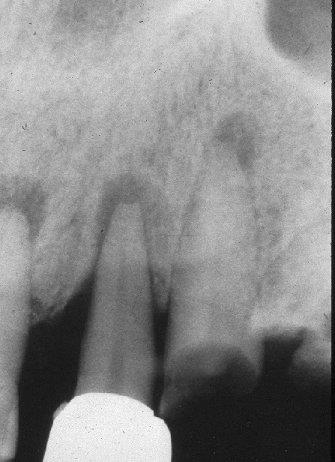

Disease name 2: Radicular cyst
Disease 2 description: A lesion with well-circumscribed borders that develop from the epithelial cell rests of Malassez. Can present as a radiolucency at the apex of a non-vital tooth, leading to root resorption and displacement of adjacent teeth.




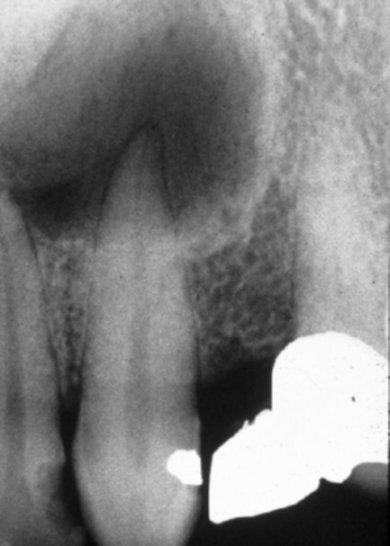

Disease name 3: Cementoma (periapical cemental dysplasia)
Disease 3 description: A radiopaque lesion that may occur in the periapical region of the lower incisors, often asymptomatic and more common in middle-aged women. Can be in different stages with varying radiographic appearances, usually without displacement or resorption of teeth.


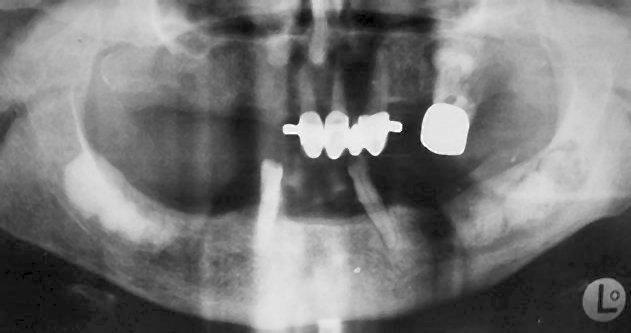

In [7]:
query = util.read_query(query_path).replace('\n', "").strip()
predictions, image_paths, context, context_indices = respond(query, text_collection_name, caption_collection_name, 3, 1)

In [8]:
print(context_indices)

['manual_individual_pages/File3_manual/Page1.txt', 'manual_individual_pages/File3_manual/Page6.txt', 'manual_individual_pages/File4_manual/Page1.txt']


# Evaluation

In [9]:
def list_respond(
        qa_pairs, 
        prediction_record_path,
        text_collection_name, 
        caption_collection_name, 
        txt_similarity_topk, 
        image_similarity_topk, 
    ):
    
    truths = []
    queries = []
    true_images = []
    true_txts = []
    for pair in qa_pairs:
        truths.append(pair['answer'])
        queries.append(pair['query'])
        true_images.append(pair['image'])
        true_txts.append(pair['page'])

    print("Generating responses.")
    prediction_record = []
        
    for i, query in tqdm(enumerate(queries)):
        cleaned_query = query.replace('\n', "")
        cleaned_query = cleaned_query.strip()
        symptom_prediction = None
        disease_names = []
        while disease_names == [] or not symptom_prediction:
            symptom_prediction, image_prediction, context, context_indices = respond(
                cleaned_query, 
                text_collection_name, 
                caption_collection_name, 
                txt_similarity_topk, 
                image_similarity_topk, 
                verbose=0
            )
            for prediction in symptom_prediction:  
                match = re.search(r'Disease name \d+:\s*(.*?)\s*Disease \d+ description:', prediction, re.DOTALL)
                if match:
                    disease_names.append(match.group(1).strip())

        record = {
            'index': i,
            'original_prediction': symptom_prediction,
            'disease_prediction': disease_names,
            'true_disease': truths[i],
            'image_prediction': image_prediction,
            'true_image': true_images[i],
            'context_indices': context_indices,
            'true_context': true_txts[i]
        }

        prediction_record.append(record)

    util.save_as_json(prediction_record, prediction_record_path)

In [10]:
def disease_recall(record_path, sparse_sim_threshold, score_path):
    prediction_record = util.load_json(record_path)
    total_correct = 0
    new_record = []
    for entry in tqdm(prediction_record):
        disease_truth_list = [entry['true_disease']]
        disease_pred = entry['disease_prediction']
        correct, sim = eval.embedding_list_hit(disease_truth_list, disease_pred, sparse_sim_threshold)

        entry['disease_correct'] = correct
        entry['sparse_similarity'] = sim
        new_record.append(entry)
        
        total_correct += correct
    
    util.save_as_json(new_record, record_path)

    if not os.path.exists(score_path):
        result = [{'disease_recall': total_correct/len(prediction_record)}]
        util.save_as_json(result, score_path)
    else:
        result = util.load_json(score_path)
        result.append([{'disease_recall': total_correct/len(prediction_record)}])
        util.save_as_json(result, score_path)

In [11]:
def retrieval_recall(record_path, score_path):
    prediction_record = util.load_json(record_path)
    total_correct = 0
    new_record = []
    for entry in tqdm(prediction_record):
        retrieval_truth_list = entry['true_context']
        retrieved = entry['context_indices']
        correct = eval.plain_list_hit(retrieval_truth_list, retrieved)

        entry['txt_retrieval_correct'] = correct
        new_record.append(entry)
        
        total_correct += correct
    
    util.save_as_json(new_record, record_path)

    if not os.path.exists(score_path):
        result = [{'txt_retrieval_recall': total_correct/len(prediction_record)}]
        util.save_as_json(result, score_path)
    else:
        result = util.load_json(score_path)
        result.append([{'txt_retrieval_recall': total_correct/len(prediction_record)}])
        util.save_as_json(result, score_path)

In [12]:
def image_recall(record_path, score_path):
    prediction_record = util.load_json(record_path)
    total_correct = 0
    new_record = []
    for entry in tqdm(prediction_record):
        truth_list = entry['true_image']
        retrieved = entry['image_prediction']
        correct = eval.plain_list_hit(truth_list, retrieved)

        entry['img_retrieval_correct'] = correct
        new_record.append(entry)
        
        total_correct += correct
    
    util.save_as_json(new_record, record_path)

    if not os.path.exists(score_path):
        result = [{'img_retrieval_recall': total_correct/len(prediction_record)}]
        util.save_as_json(result, score_path)
    else:
        result = util.load_json(score_path)
        result.append([{'img_retrieval_recall': total_correct/len(prediction_record)}])
        util.save_as_json(result, score_path)

In [13]:
exp_num = 5
util.clear_folder('manual_evaluation_results')
for i in range(exp_num):
    print(f'Evaluation Iteration {i}\n')
    qa_pairs = util.load_json('evaluation_dataset/qa_pairs.json')

    prediction_record_path = f'manual_evaluation_results/prediction_record{i}.json'

    list_respond(
        qa_pairs, 
        prediction_record_path,
        text_collection_name, 
        caption_collection_name, 
        txt_similarity_topk = 3, 
        image_similarity_topk = 1
    )

    record_path = f'manual_evaluation_results/prediction_record{i}.json'
    score_path = f'manual_evaluation_results/prediction_score{i}.json'
    disease_recall(record_path, 0.47, score_path)
    retrieval_recall(record_path, score_path)
    image_recall(record_path, score_path)


manual_evaluation_results is cleared!
manual_evaluation_results is ready for new content.
Evaluation Iteration 0

Loaded content from evaluation_dataset/qa_pairs.json
Generating responses.


25it [03:51,  9.25s/it]


Saved content to manual_evaluation_results/prediction_record0.json
Loaded content from manual_evaluation_results/prediction_record0.json


100%|██████████| 25/25 [00:38<00:00,  1.52s/it]


Saved content to manual_evaluation_results/prediction_record0.json
Saved content to manual_evaluation_results/prediction_score0.json
Loaded content from manual_evaluation_results/prediction_record0.json


100%|██████████| 25/25 [00:00<00:00, 274496.34it/s]


Saved content to manual_evaluation_results/prediction_record0.json
Loaded content from manual_evaluation_results/prediction_score0.json
Saved content to manual_evaluation_results/prediction_score0.json
Loaded content from manual_evaluation_results/prediction_record0.json


100%|██████████| 25/25 [00:00<00:00, 312076.19it/s]


Saved content to manual_evaluation_results/prediction_record0.json
Loaded content from manual_evaluation_results/prediction_score0.json
Saved content to manual_evaluation_results/prediction_score0.json
Evaluation Iteration 1

Loaded content from evaluation_dataset/qa_pairs.json
Generating responses.


25it [03:51,  9.27s/it]


Saved content to manual_evaluation_results/prediction_record1.json
Loaded content from manual_evaluation_results/prediction_record1.json


100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Saved content to manual_evaluation_results/prediction_record1.json
Saved content to manual_evaluation_results/prediction_score1.json
Loaded content from manual_evaluation_results/prediction_record1.json


100%|██████████| 25/25 [00:00<00:00, 315836.14it/s]


Saved content to manual_evaluation_results/prediction_record1.json
Loaded content from manual_evaluation_results/prediction_score1.json
Saved content to manual_evaluation_results/prediction_score1.json
Loaded content from manual_evaluation_results/prediction_record1.json


100%|██████████| 25/25 [00:00<00:00, 183317.48it/s]


Saved content to manual_evaluation_results/prediction_record1.json
Loaded content from manual_evaluation_results/prediction_score1.json
Saved content to manual_evaluation_results/prediction_score1.json
Evaluation Iteration 2

Loaded content from evaluation_dataset/qa_pairs.json
Generating responses.


25it [04:24, 10.57s/it]


Saved content to manual_evaluation_results/prediction_record2.json
Loaded content from manual_evaluation_results/prediction_record2.json


100%|██████████| 25/25 [00:11<00:00,  2.19it/s]


Saved content to manual_evaluation_results/prediction_record2.json
Saved content to manual_evaluation_results/prediction_score2.json
Loaded content from manual_evaluation_results/prediction_record2.json


100%|██████████| 25/25 [00:00<00:00, 102801.57it/s]


Saved content to manual_evaluation_results/prediction_record2.json
Loaded content from manual_evaluation_results/prediction_score2.json
Saved content to manual_evaluation_results/prediction_score2.json
Loaded content from manual_evaluation_results/prediction_record2.json


100%|██████████| 25/25 [00:00<00:00, 68266.67it/s]


Saved content to manual_evaluation_results/prediction_record2.json
Loaded content from manual_evaluation_results/prediction_score2.json
Saved content to manual_evaluation_results/prediction_score2.json
Evaluation Iteration 3

Loaded content from evaluation_dataset/qa_pairs.json
Generating responses.


25it [03:53,  9.34s/it]


Saved content to manual_evaluation_results/prediction_record3.json
Loaded content from manual_evaluation_results/prediction_record3.json


100%|██████████| 25/25 [00:01<00:00, 15.34it/s]


Saved content to manual_evaluation_results/prediction_record3.json
Saved content to manual_evaluation_results/prediction_score3.json
Loaded content from manual_evaluation_results/prediction_record3.json


100%|██████████| 25/25 [00:00<00:00, 391259.70it/s]


Saved content to manual_evaluation_results/prediction_record3.json
Loaded content from manual_evaluation_results/prediction_score3.json
Saved content to manual_evaluation_results/prediction_score3.json
Loaded content from manual_evaluation_results/prediction_record3.json


100%|██████████| 25/25 [00:00<00:00, 529583.84it/s]


Saved content to manual_evaluation_results/prediction_record3.json
Loaded content from manual_evaluation_results/prediction_score3.json
Saved content to manual_evaluation_results/prediction_score3.json
Evaluation Iteration 4

Loaded content from evaluation_dataset/qa_pairs.json
Generating responses.


25it [03:57,  9.49s/it]


Saved content to manual_evaluation_results/prediction_record4.json
Loaded content from manual_evaluation_results/prediction_record4.json


100%|██████████| 25/25 [00:05<00:00,  4.27it/s]


Saved content to manual_evaluation_results/prediction_record4.json
Saved content to manual_evaluation_results/prediction_score4.json
Loaded content from manual_evaluation_results/prediction_record4.json


100%|██████████| 25/25 [00:00<00:00, 411206.27it/s]


Saved content to manual_evaluation_results/prediction_record4.json
Loaded content from manual_evaluation_results/prediction_score4.json
Saved content to manual_evaluation_results/prediction_score4.json
Loaded content from manual_evaluation_results/prediction_record4.json


100%|██████████| 25/25 [00:00<00:00, 506558.45it/s]

Saved content to manual_evaluation_results/prediction_record4.json
Loaded content from manual_evaluation_results/prediction_score4.json
Saved content to manual_evaluation_results/prediction_score4.json
